In [1]:
import requests
from google.cloud import translate
from google.cloud import language_v1
from google.oauth2 import service_account

In [8]:
# Twitter:
bearer = open("./bearer_token.txt").read().strip()

# Google cloud:
PROJECT_ID = open("project_id.txt").read().strip()
parent=f"projects/{PROJECT_ID}/locations/global"
credentials = service_account.Credentials.from_service_account_file('credentials.json')

client = language_v1.LanguageServiceClient(credentials=credentials)
translate_client = translate.TranslationServiceClient(credentials=credentials)

In [9]:
text_type = language_v1.Document.Type.PLAIN_TEXT
language = "en"
encoding_type = language_v1.EncodingType.UTF8

In [10]:
def run_pipeline(hashtags=["covid"], language="pl", translate_client=translate_client, sentiment_client=client, parent=parent, max_results=10):
    tweets = get_tweets(lang=language, hashtags=hashtags, max_results=max_results)
    if language == "en":
        return get_sentiments(tweets, tweets), tweets[0]
    
    translations = translate_tweets(tweets, language=language)
    sentiments = get_sentiments(tweets, translations)
    return sentiments, translations[0]
    
    
def translate_tweets(tweets, language="pl", translate_client=translate_client):
    r_translate = translate_client.translate_text(request = {
        "parent": parent,
        "contents": tweets,
        "source_language_code": language,
        "target_language_code": 'en',
        "mime_type": 'text/plain'
    })
    return [r.translated_text for r in r_translate.translations]
    
    
def get_sentiments(tweets, translations, sentiment_client=client):
    results = []
    sentiments = []
    for text in translations:
        document = {"content": text, "type_": text_type, "language": language}
        response = client.analyze_sentiment(request = {'document': document, 'encoding_type': encoding_type})
        results.append(response)
        decision = 1 if response.document_sentiment.score > 0.1 else \
                   0 if response.document_sentiment.score >= -0.1 else \
                   -1        
        sentiments.append(decision)
    sentences = [sentence for r in results for sentence in r.sentences]
    mostPosId, mostPosRes = max(enumerate(results), key = lambda d: d[1].document_sentiment.score)
    mostNegId, mostNegRes = min(enumerate(results), key = lambda d: d[1].document_sentiment.score)
    return {
        'sentiments' : sentiments,
        'mostPositiveText': (mostPosRes, tweets[mostPosId], translations[mostPosId]),
        'mostNegativeText': (mostNegRes, tweets[mostNegId], translations[mostNegId]),
        'mostPositiveSentence': max(sentences, key = lambda s: s.sentiment.score),
        'mostNegativeSentence': min(sentences, key = lambda s: s.sentiment.score),
    }

def get_tweets(hashtags=["covid", "coronavirus", "koronawirus", "pandemia", "pandemic"], keywords=[], lang="pl", bearer=bearer, no_retweets=True, additional="", max_results=10):
    endpoint = f"https://api.twitter.com/2/tweets/search/recent?query="
    
    query = '(' + ' OR '.join(hashtags) + ') '
    endpoint += query
        
    for k in keywords:
        endpoint += k+" "
    
    endpoint += "lang:"+lang+" "
    
    if no_retweets:
        endpoint += "-is:retweet "
    
    endpoint += additional+" "
    
    headers = {"Authorization": f"Bearer {bearer}"}
    
    endpoint += f"&max_results={max_results}"
    r = requests.get(endpoint.encode("utf-8"), headers=headers).json()
    return [data["text"] for data in r['data']]

# Demo

In [11]:
r = get_tweets()

In [12]:
r

['@jakubiak_marek @Gnoj2013 Dlatego obiecał Doktorowi Dudzie, którego Pan wsparł w II turze wyborów Prezydenckich, że Polska jako 1 kraj otrzyma szczepionki na COVID-19. To wszystko prawda co Pan piszę. Jest Pan świetny, za 5 lat #JAKUBIAK2025',
 'Umarła dziewczyna od nas z roboty na COVID. Lat 43. Ostatnim czasy pracowała zdalnie z domu. https://t.co/1CQfpWLGJq',
 'W USA ponad 10 mln osób zaszczepiło się już przeciw Covid-19 https://t.co/5cJ0d0ro1j via @Dziennik Związkowy | Polish Daily News',
 'Koronawirus. Holandia przedłuża twardy lockdown, Belgia częściowy - po cichu\nhttps://t.co/Mie3TXYEvs',
 '@HonoriOjczyzna @GadowskiWitold @pisorgpl Akcja z pkt widzenia prawa jest nielegalna. Nie można powszechnie promować i nakłaniać do udziału w eksperymentach medycznych. A tym jest właśnie kampania na temat szczepień przeciw covid. Posłuchaj felietonu.',
 '@makowski_m Założenie dla godziny seniora to umożliwienie samotnym osobom starszym zrobienia zakupów przy zminimalizowaniu kontaktów z o

In [13]:
t = translate_tweets(r, language="pl")

In [14]:
t

['@jakubiak_marek @ Gnoj2013 That is why he promised Doctor Duda, whom you supported in the second round of the presidential elections, that Poland would receive COVID-19 vaccines as the 1st country. It is all true what you write. You are great, in 5 years time # JAKUBIAK2025',
 'Our COVID job girl died. Age 43. Recently, she has been working remotely from home. https://t.co/1CQfpWLGJq',
 'In the US, over 10 million people have already been vaccinated against Covid-19 https://t.co/5cJ0d0ro1j via @Dziennik Związek | Polish Daily News',
 'Coronavirus. The Netherlands extends the hard lockdown, Belgium partially - quietly\nhttps://t.co/Mie3TXYEvs',
 "@HonoriOjczyzna @GadowskiWitold @pisorgpl The action is illegal from the point of view of the law. One cannot universally promote and induce participation in medical experiments. And that's what the covid vaccination campaign is all about. Listen to the column.",
 '@makowski_m The assumption for the senior hour is to enable lonely elderly peo

In [23]:
s = get_sentiments(r, t)

In [24]:
s

{'sentiments': [1, 0, -1, 0, -1, 1, -1, 1, -1, -1],
 'mostPositiveText': (document_sentiment {
    magnitude: 0.699999988079071
    score: 0.699999988079071
  }
  language: "en"
  sentences {
    text {
      content: "@angeliquedeberg @adas_torun @docent_ws I recommend a nice review\nhttps://t.co/atbZNUy1qa"
    }
    sentiment {
      magnitude: 0.699999988079071
      score: 0.699999988079071
    }
  },
  '@angeliquedeberg @adas_torun @docent_ws Polecam fajny przegląd\nhttps://t.co/atbZNUy1qa',
  '@angeliquedeberg @adas_torun @docent_ws I recommend a nice review\nhttps://t.co/atbZNUy1qa'),
 'mostNegativeText': (document_sentiment {
    magnitude: 1.7999999523162842
    score: -0.4000000059604645
  }
  language: "en"
  sentences {
    text {
      content: "@HonoriOjczyzna @GadowskiWitold @pisorgpl The action is illegal from the point of view of the law."
    }
    sentiment {
      magnitude: 0.699999988079071
      score: -0.699999988079071
    }
  }
  sentences {
    text {
      

In [26]:
def get_name(n):
    if n==1:
        return "Positive"
    elif n==0:
        return "Neutral"
    return "Negative"

In [27]:
summary = [f"Original tweet: {tweet}\n Translated tweet: {translation}\n Sentiment: {get_name(sentiment)}" for tweet, translation, sentiment in zip(r, t, s['sentiments'])]

In [28]:
for i in summary[:4]:
    print(i)
    print()

Original tweet: @jakubiak_marek @Gnoj2013 Dlatego obiecał Doktorowi Dudzie, którego Pan wsparł w II turze wyborów Prezydenckich, że Polska jako 1 kraj otrzyma szczepionki na COVID-19. To wszystko prawda co Pan piszę. Jest Pan świetny, za 5 lat #JAKUBIAK2025
 Translated tweet: @jakubiak_marek @ Gnoj2013 That is why he promised Doctor Duda, whom you supported in the second round of the presidential elections, that Poland would receive COVID-19 vaccines as the 1st country. It is all true what you write. You are great, in 5 years time # JAKUBIAK2025
 Sentiment: Positive

Original tweet: Umarła dziewczyna od nas z roboty na COVID. Lat 43. Ostatnim czasy pracowała zdalnie z domu. https://t.co/1CQfpWLGJq
 Translated tweet: Our COVID job girl died. Age 43. Recently, she has been working remotely from home. https://t.co/1CQfpWLGJq
 Sentiment: Neutral

Original tweet: W USA ponad 10 mln osób zaszczepiło się już przeciw Covid-19 https://t.co/5cJ0d0ro1j via @Dziennik Związkowy | Polish Daily News


# Whole pipeline:

### Sentiments in Poland:

In [208]:
r, _ = run_pipeline(language = 'pl')

### Sentiments in Spain:

In [209]:
r, _ = run_pipeline(language = 'es')

## Languages
English (default) en  
Arabic  ar  
Bengali bn  
Czech cs  
Danish  da  
German  de  
Greek el  
Spanish es  
Persian fa  
Finnish fi  
Filipino  fil  
French  fr  
Hebrew  he  
Hindi hi  
Hungarian hu  
Indonesian  id  
Italian it  
Japanese  ja  
Korean  ko  
Malay msa  
Dutch nl  
Norwegian no  
Polish  pl  
Portuguese  pt  
Romanian  ro  
Russian ru  
Swedish sv  
Thai  th  
Turkish tr  
Ukrainian uk  
Urdu  ur  
Vietnamese  vi  
Chinese (Simplified)  zh-cn  
Chinese (Traditional) zh-tw  

In [29]:
import time
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")

In [30]:
def plot_sentiments(results, hashtags):
    formatted_data = []
    columns=["country", "percentPos", "percentNeut", "percentNeg"]
    
    for language, data in results.items():
        allNumber = len(data)
        positiveNumber = len(list(filter(lambda f: f == 1, data)))
        neutralNumber = len(list(filter(lambda f: f == 0, data)))
        negativeNumber = len(list(filter(lambda f: f == -1, data)))
        positivePerc = (positiveNumber / allNumber * 100) if positiveNumber != 0 else 0
        neutralPerc = (neutralNumber / allNumber * 100) if neutralNumber != 0 else 0
        negativePerc = (negativeNumber / allNumber * 100) if negativeNumber != 0 else 0    
        formatted_data.append((language, positivePerc, neutralPerc, negativePerc))
        
    df = pd.DataFrame(formatted_data, columns=columns)
    
    df.plot( 
      x = 'country',  
      kind = 'barh',  
      stacked = True,  
      title = f'Sentiment for tweets with hashtags: {hashtags} per country',
      mark_right = True,
      color=['g', 'b', 'r'],
     figsize=(14,8))
    plt.legend(["Percent of positive tweets", "Percent of neutral tweets", "Percent of negative tweets"])
    
    

In [38]:
from IPython.display import Markdown, display

def analyze_twitter(languages, hashtags=["covid"], streaming=False, max_results=10):
    results = {}
    newest_tweets = {}
    
    while True:
        clear_output(wait=True)
        for language in languages:
            pipelineResults, newestTweet = run_pipeline(language=language, hashtags=hashtags, max_results=max_results)
            results[language] = pipelineResults['sentiments']

            if streaming:
                newest_tweets[language] = newestTweet
            else:
                mostPosScore = round(pipelineResults['mostPositiveText'][0].document_sentiment.score, 2)
                mostPosOriginalText = pipelineResults['mostPositiveText'][1]
                mostPosEnText = pipelineResults['mostPositiveText'][2]
                mostNegScore = round(pipelineResults['mostNegativeText'][0].document_sentiment.score, 2)
                mostNegOriginalText = pipelineResults['mostNegativeText'][1]
                mostNegEnText = pipelineResults['mostNegativeText'][2]
                mostPosSentenceScore = round(pipelineResults['mostPositiveSentence'].sentiment.score, 2)
                mostPosSentenceEnText = pipelineResults['mostPositiveSentence'].text.content
                mostNegSentenceScore = round(pipelineResults['mostNegativeSentence'].sentiment.score, 2)
                mostNegSentenceEnText = pipelineResults['mostNegativeSentence'].text.content

                display(Markdown(f'**Language: {language}**<br>**Most positive tweet ({mostPosScore}):**<br>{mostPosOriginalText}<br>{mostPosEnText}<br>'))
                display(Markdown(f'**Most negative tweet ({mostNegScore}):**<br>{mostNegOriginalText}<br>{mostNegEnText}<br>'))
                display(Markdown(f'**Most positive sentence ({mostPosSentenceScore}):**<br>{mostPosSentenceEnText}<br>'))
                display(Markdown(f'**Most negative sentence ({mostNegSentenceScore}):**<br>{mostNegSentenceEnText}<br>'))
                print()
            
        plot_sentiments(results, hashtags)
        if not streaming:
            return
        for lang, newest in newest_tweets.items():
            print(f"Newest tweet translated form language {lang}:")
            print(newest+"\n")
        plt.show()
        time.sleep(10)
        

# Analysis Mode

**Language: pl**<br>**Most positive tweet (0.2):**<br>@jakubiak_marek @Gnoj2013 Dlatego obiecał Doktorowi Dudzie, którego Pan wsparł w II turze wyborów Prezydenckich, że Polska jako 1 kraj otrzyma szczepionki na COVID-19. To wszystko prawda co Pan piszę. Jest Pan świetny, za 5 lat #JAKUBIAK2025<br>@jakubiak_marek @ Gnoj2013 That is why he promised Doctor Duda, whom you supported in the second round of the presidential elections, that Poland would receive COVID-19 vaccines as the 1st country. It is all true what you write. You are great, in 5 years time # JAKUBIAK2025<br>

**Most negative tweet (-0.7):**<br>@tula_uwu acha a ja myslalam zeby otworzyc zeby larries sie tam pozarazaly przes covid i wyginely ..<br>@tula_uwu aha, and I thought to open the larries there, they got lost in covid and they died out ..<br>

**Most positive sentence (0.9):**<br>You are great, in 5 years time # JAKUBIAK2025<br>

**Most negative sentence (-0.7):**<br>@tula_uwu aha, and I thought to open the larries there, they got lost in covid and they died out ..<br>

**Language: en**<br>**Most positive tweet (0.2):**<br>@RoKhanna 1. covid vaccine rollout to 80% of the pop
2. medicare for all
3. dc statehood
4. puerto rico statehood vote to pr pop
5. rebalance supreme court
6. ubi for pandemic times and replace unemployment with it
7. undo trump tax cut

One per week, room for 8 more...<br>@RoKhanna 1. covid vaccine rollout to 80% of the pop
2. medicare for all
3. dc statehood
4. puerto rico statehood vote to pr pop
5. rebalance supreme court
6. ubi for pandemic times and replace unemployment with it
7. undo trump tax cut

One per week, room for 8 more...<br>

**Most negative tweet (-0.8):**<br>@GovStitt And yet you still act like you don’t know what would help the covid situation in our state!!! Quit using kids as a smokescreen for your inaction.<br>@GovStitt And yet you still act like you don’t know what would help the covid situation in our state!!! Quit using kids as a smokescreen for your inaction.<br>

**Most positive sentence (0.4):**<br>ubi for pandemic times and replace unemployment with it
7.<br>

**Most negative sentence (-0.8):**<br>when we believe it has materially contributed to the death i.e. caused it.<br>

**Language: de**<br>**Most positive tweet (0.2):**<br>Ich prophezeie Covid 21👏🏼<br>I predict Covid 21👏🏼<br>

**Most negative tweet (-0.8):**<br>ICN: Der COVID-19-Effekt: Die Krankenpflegefachkräfte der Welt sind einem Massentrauma ausgesetzt, einer unmittelbaren Gefahr für den Beruf und die Zukunft unserer Gesundheitssysteme https://t.co/cOJbZ5U4Id<br>ICN: The COVID-19 Effect: The world's nursing professionals are exposed to mass trauma, an imminent threat to the job and the future of our health systems https://t.co/cOJbZ5U4Id<br>

**Most positive sentence (0.3):**<br>https://t.co/bFAJXFTerV<br>

**Most negative sentence (-0.8):**<br>They do not understand why the Federal Council does not want to reintroduce this tried-and-tested instrument immediately, but only wants to examine it."<br>

**Language: fr**<br>**Most positive tweet (0.4):**<br>@mandastd Depuis le 1er y’a eu quand même la coupe du monde, la CAN, le Brexit , le covid, un voyage sur mars, 2021...c’est incroyable quand même<br>@mandastd Since the 1st there has been the World Cup, CAN, Brexit, Covid, a trip to March, 2021 ... it's unbelievable anyway<br>

**Most negative tweet (-0.7):**<br>Covid-19 : la fermeture des écoles, une plaie pour les enfants les plus pauvres via @franceinter https://t.co/eRw6tIlmxP<br>Covid-19: the closure of schools, a plague for the poorest children via @franceinter https://t.co/eRw6tIlmxP<br>

**Most positive sentence (0.4):**<br>I cannot imagine another hypothesis.<br>

**Most negative sentence (-0.7):**<br>Covid-19: the closure of schools, a plague for the poorest children via @franceinter https://t.co/eRw6tIlmxP<br>

**Language: ru**<br>**Most positive tweet (0.1):**<br>В Хабаровский край привезли две тысячи доз вакцины от COVID-19. РИА https://t.co/VxKmH4Iwml<br>Two thousand doses of COVID-19 vaccine were brought to the Khabarovsk Territory. RIA https://t.co/VxKmH4Iwml<br>

**Most negative tweet (-0.3):**<br>@DimanKorzh Все вакцины в мире допущены с нарушением традиционных процедур. Ну и вы говорите про эффективность. Даже если у него эффективность 20% и серьезные побочки на уровне ниже 1%. То уже рационально им привиться. От COVID-19 не спрячешься на достаточно длительном отрезке времени.<br>@DimanKorzh All vaccines in the world are approved in violation of traditional procedures. Well, you're talking about efficiency. Even if it has an efficiency of 20% and serious side effects at a level below 1%. It is already rational to graft on them. You cannot hide from COVID-19 for a sufficiently long period of time.<br>

**Most positive sentence (0.7):**<br>But without a vaccine, I will definitely get it.<br>

**Most negative sentence (-0.7):**<br>The maximum will not be effective and I will still get infected with COVID-19.<br>

**Language: zh**<br>**Most positive tweet (0.2):**<br>疫苗研发又一大好消息，强生制药的疫苗有效安全，只需要一次接种，简化了手续。现在的结果是七百多人的群组，更大规模4万五千人的对比研究将于月底完成，如果顺利通过，下月初可投入
#Covid19 vaccine: Johnson &amp; Johnson one-shot safe, generates immune response https://t.co/QIcqF00XMP<br>Another great news for vaccine development is that Johnson & Johnson's vaccines are effective and safe, requiring only one vaccination, simplifying procedures. The current result is a group of more than 700 people. A larger comparative study of 45,000 people will be completed at the end of the month. If it passes successfully, it can be put into operation early next month.
#Covid19 vaccine: Johnson &amp; Johnson one-shot safe, generates immune response https://t.co/QIcqF00XMP<br>

**Most negative tweet (-0.7):**<br>Covid在马达加斯加先造成社会危机 https://t.co/R6pPMEce9d https://t.co/afAHCUgN5S<br>Covid first caused a social crisis in Madagascar https://t.co/R6pPMEce9d https://t.co/afAHCUgN5S<br>

**Most positive sentence (0.8):**<br>Another great news for vaccine development is that Johnson & Johnson's vaccines are effective and safe, requiring only one vaccination, simplifying procedures.<br>

**Most negative sentence (-0.8):**<br>PCR fraud = false prevalence
 https://t.co/NKdOSxvhV4<br>

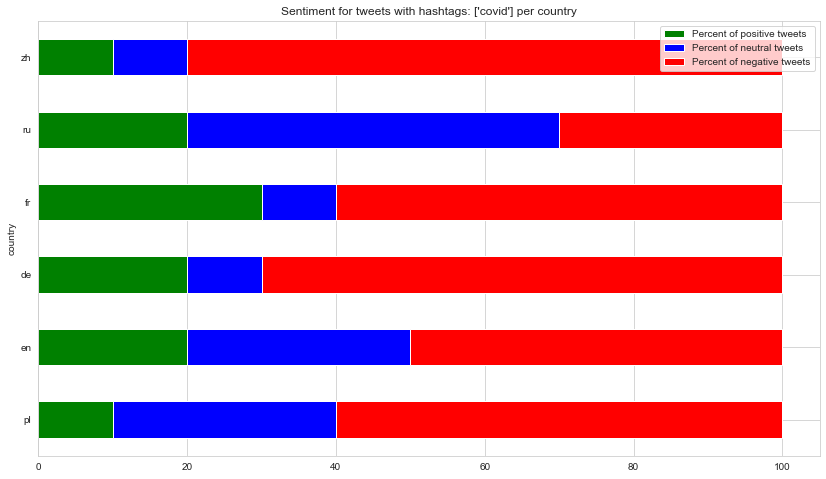

In [32]:
analyze_twitter(['pl', 'en', 'de', 'fr', 'ru', 'zh'], ["covid"])

**Language: pl**<br>**Most positive tweet (0.5):**<br>Trump przyjął Pence'a w Białym Domu. „Dobra rozmowa” https://t.co/Hm6hMFrulN #wieszwiecej<br>Trump welcomed Pence at the White House. "Good conversation" https://t.co/Hm6hMFrulN #wieszwiecej<br>

**Most negative tweet (-0.4):**<br>"Donald Trump został oskarżony o "podżeganie do powstania". To już druga próba odsunięcia prezydenta USA od władzy. Amerykańska polityka nie miała jeszcze takiego przypadku w swojej historii"
https://t.co/bf5OCqkBAH<br>"Donald Trump has been accused of" inciting an insurrection ". This is the second attempt to remove the US president from power. American politics has not yet had such a case in its history.
https://t.co/bf5OCqkBAH<br>

**Most positive sentence (0.8):**<br>999,500 people demonstrate calmly.<br>

**Most negative sentence (-0.8):**<br>Trump will not become president anyway.<br>

**Language: en**<br>**Most positive tweet (0.1):**<br>ONE For All, All FOR ONE. In JOE BIDEN WE DO NOT TRUST. in Trump we do trust. copy paste everywhere you can. you are a real patriot. thanks for peacefully fighting  for TRUMP And We The PEOPLE. STOP ALL DONATIONS To DEMOCRATS AND REPUBLICANS. great never more!
 PATRIOTIC PARTY https://t.co/PMngQv4hAG<br>ONE For All, All FOR ONE. In JOE BIDEN WE DO NOT TRUST. in Trump we do trust. copy paste everywhere you can. you are a real patriot. thanks for peacefully fighting  for TRUMP And We The PEOPLE. STOP ALL DONATIONS To DEMOCRATS AND REPUBLICANS. great never more!
 PATRIOTIC PARTY https://t.co/PMngQv4hAG<br>

**Most negative tweet (-0.6):**<br>Trump is a criminal asshole 👇👇 https://t.co/dcCed4Sf4N<br>Trump is a criminal asshole 👇👇 https://t.co/dcCed4Sf4N<br>

**Most positive sentence (0.9):**<br>great never more!<br>

**Most negative sentence (-0.9):**<br>@besttakess @JoeBiden Dummy your speaking for yourself and all the other ignorant fools who supported violence against our country and its Democratic processes.<br>

**Language: de**<br>**Most positive tweet (0.6):**<br>@MarkHauptmann @_FriedrichMerz @CDU Hat auch in den USA gut geklappt!
@_FriedrichMerz ist der deutsche #Trump!
#WirAlleGegenMerz 
#MenschenGegenMerz 
#MerzVerhindern<br>@MarkHauptmann @_FriedrichMerz @CDU also worked well in the USA!
@_FriedrichMerz is the German #Trump!
#WeAll AgainstMerz
#People AgainstMerz
#MerzPrevent<br>

**Most negative tweet (-0.7):**<br>@holgereluard Trump pompeo sanktionieren Kuba,  wegen terrorfinanzierung
Der Mob wird von der US Regierung unterstützt damit unterstützt die US Regierung  genauso terrorbewegungen #capitolriots<br>@holgereluard Trump pompeo sanction Cuba for terrorist financing
The mob is supported by the US government so the US government also supports terror movements #capitolriots<br>

**Most positive sentence (0.8):**<br>What a historic evening 😂👍 #ImpeachmentDay #KSVFCB<br>

**Most negative sentence (-0.8):**<br>Fake news is being shot because the women's union clearly NOT in favor of "Trump from 🇩🇪"?<br>

**Language: fr**<br>**Most positive tweet (0.0):**<br>la chambre des députés va procéder à l' acheminement de l'article de destitution au senat pour le procès de Donald Trump . selon le leader republiquain Mitch MC Connell il n' est pas probable qu'un procès aura lieu le 19 Jan avant l'investiture du president élu Joe Biden. https://t.co/RRog9JveXo<br>the chamber of deputies will proceed to forward the article of impeachment to the senate for the trial of Donald Trump. according to the republican leader Mitch MC Connell it is not probable that a trial will take place on Jan. 19 before the inauguration of the elected president Joe Biden. https://t.co/RRog9JveXo<br>

**Most negative tweet (-0.6):**<br>@FlockRen Je lis que l'insurrection act a été signé le WE dernier, mais ne serait révélé qu'en temps voulu : je ne serai pas étonné que celui-ci ait "protégé" Donald Trump de tout nouveau délire de ce genre, auquel cas l'ouverture de cette nlle procédure de destitution serait sans effet...<br>@FlockRen I read that the insurgency act was signed last WE, but would only be revealed in due course: I will not be surprised that this one has "protected" Donald Trump from any new delirium of this kind, to which case the opening of this new dismissal procedure would have no effect ...<br>

**Most positive sentence (0.5):**<br>Like what 😳
 https://t.co/1tNQRuGtUC<br>

**Most negative sentence (-0.8):**<br>It's a coup, but with morons ...<br>

**Language: ru**<br>**Most positive tweet (0.0):**<br>Телеграм-канал @trump, куда ретранслировались твиты, и который все приняли за официальный канал президента США, сам Телеграм пометил, как канал мошенников. https://t.co/MNfhHN2xAI<br>The Telegram channel @trump, where the tweets were relayed, and which everyone took for the official channel of the President of the United States, Telegram itself marked as a scam channel. https://t.co/MNfhHN2xAI<br>

**Most negative tweet (-0.7):**<br>Демократопитеки-коммунисты-онанисты хотят запретить #РыжемуКонопатомуТрампу баллотироваться на пост президента https://t.co/yUHVbO7DZr #США #Трамп #Trump<br>Democratic-topitic communist masturbators want to ban #RedConopathomTrump from running for president https://t.co/yUHVbO7DZr #USA #Trump #Trump<br>

**Most positive sentence (0.5):**<br>Now there is no doubt that all this time the page https://t.co/azftD5fjZs<br>

**Most negative sentence (-0.8):**<br>But do not rush to accuse Durov of censorship.<br>

**Language: zh**<br>**Most positive tweet (0.3):**<br>@CaoChangqing @HaoJiao2018 覺醒的美國人加油
你們是自由的先驅
正義會遲到但從不缺席
邪不能勝正
May Lord blessing President Trump and His family 🙏
God bless America 🙏 
#fourmoreyears 
#welovetrump
#americagreatagain
#fightforfreedom<br>@CaoChangqing @HaoJiao2018 Come on, the awakened Americans
You are the pioneers of freedom
Justice will be late but never absent
Evil cannot conquer the right
May Lord blessing President Trump and His family 🙏
God bless America 🙏
#fourmoreyears
#welovetrump
#americagreatagain
#fightforfreedom<br>

**Most negative tweet (-0.6):**<br>此外，请那些把Trump比作Lincoln的朋友搞清楚一个基本事实：Lincoln打赢了南北战争，带给美国新生；而本次大选保守派经历了几乎是有史以来最惨痛的失败，美国已濒临死亡。Trump没能完成自己的承诺，他远不如Lincoln。从政治立场来说，他是Reagan之后最符合保守主义价值观的，但是仅论结果则颇为糟糕。<br>In addition, those friends who compare Trump to Lincoln are asked to clarify a basic fact: Lincoln won the Civil War and brought new life to the United States; and the conservatives in this election experienced almost the worst defeat in history, and the United States is on the verge of death. . Trump failed to fulfill his promise, he was far inferior to Lincoln. From a political standpoint, he is the most consistent with conservative values after Reagan, but the results alone are quite bad.<br>

**Most positive sentence (0.9):**<br>thank you all!<br>

**Most negative sentence (-0.9):**<br>However, what troubles Koyré the most is that a lie does not even need to sound reasonable to work.<br>

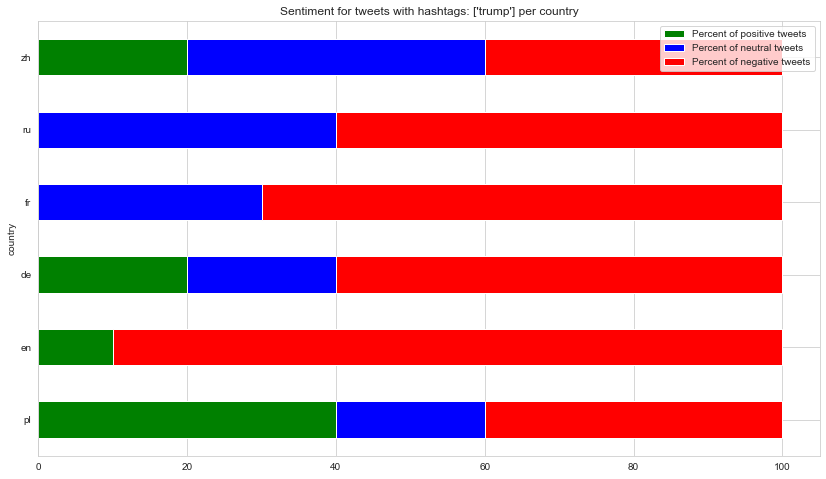

In [36]:
analyze_twitter(['pl', 'en', 'de', 'fr', 'ru', 'zh'], ["trump"])

# Streaming mode

Newest tweet translated form language pl:
@ tomo9000p @Michal_Sestero @ Hubert66055422 It will make him a martyr only among the supporters, which is irrelevant, because the vast majority of them are civically like zombies - "everyone is lying, democracy is dead, the earth is flat, covid does not exist, there are chips in vaccines, only whites are people. "

Newest tweet translated form language en:
Getting my first dose of the COVID vaccine.

Newest tweet translated form language de:
01/13/21 COVID-19 in 🇩🇪:
New infections do not necessarily mean more seriously ill, that is what virologists say, and the numbers confirm it:
§Approx. 2.0 million infected people (excluding the real figure!)
§DIVI, nationwide 5,185 intensive care cases, 57% of them in artificial ventilation https://t.co/QGEjoeZI74

Newest tweet translated form language fr:
If you are told strict total containment until May then and the covid disappears, do you take?

Newest tweet translated form language ru:
Putin ordered 

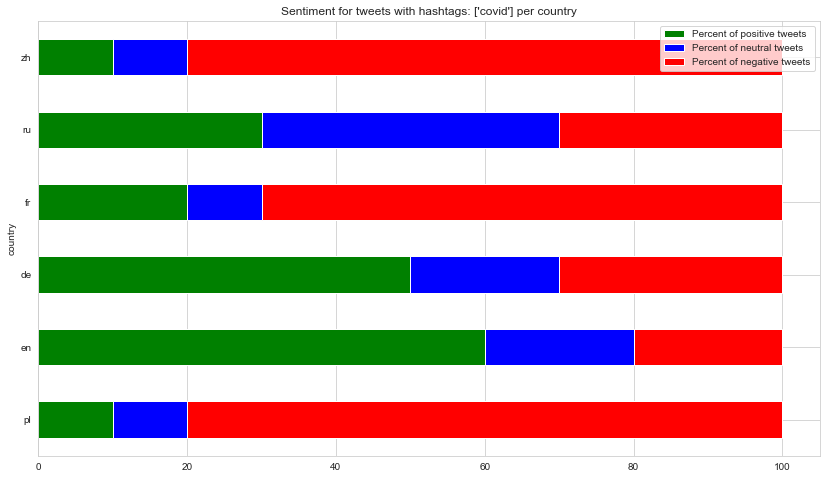

KeyboardInterrupt: 

In [39]:
analyze_twitter(['pl', 'en', 'de', 'fr', 'ru', 'zh'], ["covid"], streaming=True)

# Large amount of data analysis

### Possibly negative tweets:

**Language: hi**<br>**Most positive tweet (0.7):**<br>राजस्थान से अच्छी खबर, नए कोरोना संक्रमितों के दोगुने से भी ज्यादा रही ठीक होने वालों की संख्या
https://t.co/voJyAZv5UT<br>Good news from Rajasthan, number of people recovering more than double of new corona infected
https://t.co/voJyAZv5UT<br>

**Most negative tweet (-0.8):**<br>Bcz of this idiot corona uttarayan bhi maybe achhe se nahi mana payenge is bar🌚😭
Sare festivals ki ek do karke rakhi hai is nalayak covid ne to😤<br>Bcz of this idiot corona uttarayan bhi maybe achhe se nahi mana payenge is bar🌚😭
Sare festivals ki ek do karke rakhi hai is nalayak covid ne to😤<br>

**Most positive sentence (0.9):**<br>Great relief for the Jabalpur residents.<br>

**Most negative sentence (-0.8):**<br>Politics is a bad thing, Italy is going through a difficult period of Covid and today a large ally of the present government withdrew its support from the government ...<br>

**Language: ja**<br>**Most positive tweet (0.9):**<br>コロナ禍の医療現場で大活躍、ファクスを自動で読み取るAIの実力 https://t.co/erSPT0tI5a<br>Great success in the medical field of corona virus, the ability of AI to automatically read faxes https://t.co/erSPT0tI5a<br>

**Most negative tweet (-0.8):**<br>@makura_nemuizzz スペイン風邪はただのインフルエンザになったし、COVID-19も嵐が過ぎ去ってただの風邪になるの待つしかないかな<br>@makura_nemuizzz The Spanish flu has become just a flu, and COVID-19 has no choice but to wait for the storm to pass and become just a cold.<br>

**Most positive sentence (0.9):**<br>I'm grateful that it's close, and it's a little reunion.<br>

**Most negative sentence (-0.8):**<br>@makura_nemuizzz The Spanish flu has become just a flu, and COVID-19 has no choice but to wait for the storm to pass and become just a cold.<br>

**Language: pt**<br>**Most positive tweet (0.9):**<br>A pq 23 de fevereiro o covid já vai ter acabado kkkkkk, realmente muito útil o adiamento👏👏 https://t.co/zrSUFbctVW<br>Because February 23 the covid will have finished kkkkkk, really very useful the postponement👏👏 https://t.co/zrSUFbctVW<br>

**Most negative tweet (-0.9):**<br>@diariodamanha Isso é pra vcs aprenderem que o Covid veio pra ensina-los que os ricos e politicos tambem morrem, pensem nisso, tenham mais umildade, e pra vcs politicos, parem de roubar, pq uma hora vcs são cobrados.<br>@diariodamanha This is for you to learn that Covid came to teach you that the rich and politicians also die, think about it, have more humility, and for you politicians, stop stealing, because one hour you are charged.<br>

**Most positive sentence (0.9):**<br>I tattooed the spring day song that has a special meaning for me and helped me in the process of mourning her handwriting.<br>

**Most negative sentence (-0.9):**<br>@kthnerd Pq bolsonaristas and toucanos do not stop screwing our people because of politics.<br>

**Language: pl**<br>**Most positive tweet (0.8):**<br>@Kchmiel95 @LeszekDudek @boxingfun To dobrze. Ryzyko powikłań poszczepiennych jest znacznie mniejsze niż ryzyko powikłań wywołanych zakażeniem Covid.<br>@ Kchmiel95 @LeszekDudek @boxingfun That's good. The risk of vaccine complications is much lower than the risk of complications from Covid infection.<br>

**Most negative tweet (-0.9):**<br>@Tom3kM @Dekantacja @Parchem_Mateusz Hojrakuj póki możesz jak cię covid jebnie to rodzina za firmą będzie płakać nie za tobą.<br>@ Tom3kM @Dekantacja @Parchem_Mateusz Hojrakuj as long as you can covid you fucking, the family behind the company will cry not for you.<br>

**Most positive sentence (0.9):**<br>The risk of vaccine complications is much lower than the risk of complications from Covid infection.<br>

**Most negative sentence (-0.9):**<br>@ Tom3kM @Dekantacja @Parchem_Mateusz Hojrakuj as long as you can covid you fucking, the family behind the company will cry not for you.<br>

**Language: en**<br>**Most positive tweet (0.9):**<br>@danjlevy Thank you.  I couldn’t have survived COVID without this family.<br>@danjlevy Thank you.  I couldn’t have survived COVID without this family.<br>

**Most negative tweet (-0.8):**<br>Yooo people are getting Covid left and RIGHT smh<br>Yooo people are getting Covid left and RIGHT smh<br>

**Most positive sentence (0.9):**<br>I couldn’t have survived COVID without this family.<br>

**Most negative sentence (-0.9):**<br>You disappoint us.<br>

**Language: de**<br>**Most positive tweet (0.6):**<br>@Tayronlivereal Alles alles gute dir mein Lieber! Bei mir war Covid auch schon im Haus und es hat auch im Krankenhaus geendet, aber nicht so schlimm wie bei dir. Dir alles alles gute! Gute Besserung und hoffentlich ohne irgendwelche Spätfolgen.<br>@Tayronlivereal All the best to you my dear! Covid was already in my house and it also ended in the hospital, but not as bad as yours. All the best to you! Get well soon and hopefully without any after-effects.<br>

**Most negative tweet (-0.9):**<br>Habe gerade nach längerer Zeit mal wieder "Covid-19" statt "Corona" wo gelesen und dann fiel mir wieder ein, dass der Scheiß einfach in fucking 2019 anfing. Sad.<br>Just after a long time I read "Covid-19" instead of "Corona" and then I remembered that the shit just started in fucking 2019. Sad.<br>

**Most positive sentence (0.9):**<br>One of many heroes!<br>

**Most negative sentence (-0.9):**<br>Just after a long time I read "Covid-19" instead of "Corona" and then I remembered that the shit just started in fucking 2019.<br>

**Language: fr**<br>**Most positive tweet (0.9):**<br>Le Covid nous éloigne les uns des autres.<br>The Covid keeps us away from each other.<br>

**Most negative tweet (-0.8):**<br>@yonkomatieu C'est pas par là qu'il faut le mettre pour faire le test covid...<br>@yonkomatieu This is not where it should be put to do the covid test ...<br>

**Most positive sentence (0.9):**<br>It is indeed a major success, the hallmark of senior strategists.<br>

**Most negative sentence (-0.8):**<br>@yonkomatieu This is not where it should be put to do the covid test ...<br>

**Language: ru**<br>**Most positive tweet (0.4):**<br>бывший возлюбленный прислал фотографию себя с красными глазами и подписью weed лечит covid ну а что сразу понятно как у человека дела мне нравится<br>a former lover sent a photo of himself with red eyes and the signature weed treats covid, but what is immediately clear how a person is doing I like<br>

**Most negative tweet (-0.8):**<br>Американские врачи назвали опасные при лечении COVID-19 препараты https://t.co/tRL4P4qbGg<br>American doctors called drugs dangerous in the treatment of COVID-19 https://t.co/tRL4P4qbGg<br>

**Most positive sentence (0.8):**<br>Long live people!<br>

**Most negative sentence (-0.9):**<br>who to send the fuck and then you don't have to choose luck ...<br>

**Language: zh**<br>**Most positive tweet (0.3):**<br>尽你所能。 
预防抵抗新冠病毒COVID-19。

https://t.co/FzPDUinPu6 https://t.co/QavRXVuS1d<br>try your best.
Prevent and fight against the new coronavirus COVID-19.

https://t.co/FzPDUinPu6 https://t.co/QavRXVuS1d<br>

**Most negative tweet (-0.7):**<br>Covid在马达加斯加先造成社会危机 https://t.co/R6pPMEce9d https://t.co/afAHCUgN5S<br>Covid first caused a social crisis in Madagascar https://t.co/R6pPMEce9d https://t.co/afAHCUgN5S<br>

**Most positive sentence (0.9):**<br>Authentic, conservative and traditional.<br>

**Most negative sentence (-0.9):**<br>I asked you if the result came out, you said no, in fact I know you are negative, you never know why I would know you are negative, you can lie to me for a woman and say that you are suspecting covid, you know I sorted Well, go home, and slowly add that woman to your previous actions, I know I was fooled by you again.<br>

**Language: es**<br>**Most positive tweet (0.8):**<br>Casos activos de Covid-19 siguen en alza por undécimo día consecutivo llegando a 23.407, y la positividad es la más alta en los últimos 8 días https://t.co/wzE70Oyudt https://t.co/J1u7KT5NtV<br>Active cases of Covid-19 continue to rise for the eleventh consecutive day reaching 23,407, and the positivity is the highest in the last 8 days https://t.co/wzE70Oyudt https://t.co/J1u7KT5NtV<br>

**Most negative tweet (-0.8):**<br>#Guanajuato 🏫😡 Varios planteles fueron robados más de una vez https://t.co/p5ciTf8nkR<br>#Guanajuato 🏫😡 Several schools were stolen more than once https://t.co/p5ciTf8nkR<br>

**Most positive sentence (0.8):**<br>Let's all take care of ourselves, let's continue with sanitary measures and stay at home, it helps to reduce infections by # Covid_19mx.<br>

**Most negative sentence (-0.9):**<br>You really are damaged.<br>

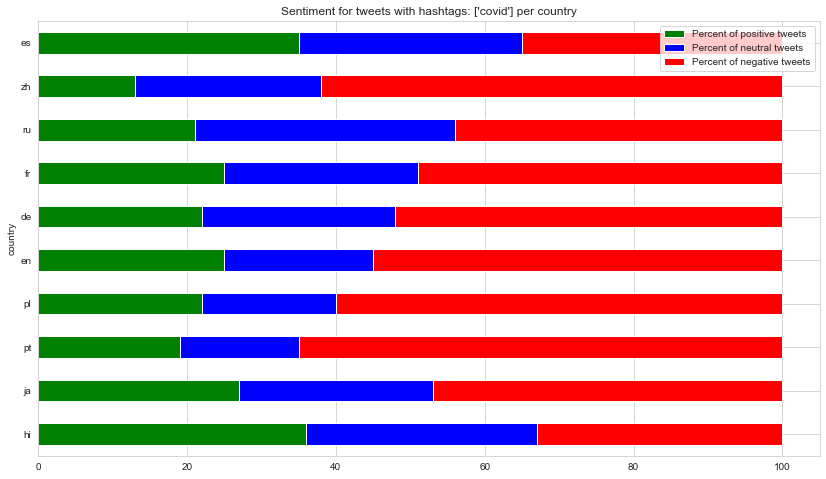

In [40]:
analyze_twitter(['hi', 'ja', 'pt', 'pl', 'en', 'de', 'fr', 'ru', 'zh', 'es'], ["covid"], max_results=100)

### Possibly positive subject

**Language: hi**<br>**Most positive tweet (0.9):**<br>AKSHAKSH I LOVE HIM https://t.co/LZZ3GQj6og<br>AKSHAKSH I LOVE HIM https://t.co/LZZ3GQj6og<br>

**Most negative tweet (-0.6):**<br>@love_tearsss @colors512346 @RubiDilaik Bichare Mohalle ki aunty logo ki insult nai karo inke sath compare karke.<br>@love_tearsss @ colors512346 @RubiDilaik Bichare Mohalle ki aunty logo ki insult nai karo inke sath compare karke.<br>

**Most positive sentence (0.9):**<br>Love u..😍<br>

**Most negative sentence (-0.8):**<br>Her desperation is showing through ....<br>

**Language: ja**<br>**Most positive tweet (0.9):**<br>@52_love_sayaka おはよ！<br>@ 52_love_sayaka Good morning!<br>

**Most negative tweet (-0.8):**<br>Girlfriends told me that they hated their first experience. That's because they didn't love their guys. 
私の友達は初体験を大切にしない。好きでもない男と平気で<br>Girlfriends told me that they hated their first experience. That's because they didn't love their guys.
My friends don't value their first experience. With a man I don't like<br>

**Most positive sentence (0.9):**<br>@KevanKenney SexyZone a.k.a SZ
🌹 #TopJRecords
I LOVE #SZ music!<br>

**Most negative sentence (-0.8):**<br>Simple guessing is hard
Idols have the same support for DD and simple guessing
I'm dissatisfied because I want less as much as I guess
(When you go to another site, your back finger is pointed)
Hide your likes so that it doesn't happen<br>

**Language: pt**<br>**Most positive tweet (0.9):**<br>te amo mil milhões — i love you 3000 https://t.co/Pt9IlQ5C4k<br>love you a billion - i love you 3000 https://t.co/Pt9IlQ5C4k<br>

**Most negative tweet (-0.8):**<br>@Love_and_darkS2 Pera sério ? Kkkk indignada<br>@ Love_and_darkS2 Are you serious? Kkkk outraged<br>

**Most positive sentence (0.9):**<br>love you a billion - i love you 3000 https://t.co/Pt9IlQ5C4k<br>

**Most negative sentence (-0.8):**<br>@ Love_and_darkS2 Are you serious?<br>

**Language: pl**<br>**Most positive tweet (0.9):**<br>@Springfieldres1 love u too uwu<br>@ Springfieldres1 love u too uwu<br>

**Most negative tweet (-0.7):**<br>@I_love_uyu_skz_ ja rozumiem że każdy inaczej odbiera i postrzega swój ideał jednak zamiast reagować w taki sposób wystarczyło napisać że nie jest to jej typ ideału i tyle jeszcze wtedy nie dawała by ci powodu do przykrości<br>@I_love_uyu_skz_ I understand that everyone receives and perceives their ideal differently, but instead of reacting in such a way, it was enough to write that it is not her type of ideal and then it would not give you a reason to feel sorry<br>

**Most positive sentence (0.9):**<br>The new playlist "i'm in love with these rn" has just been made public on Spotify!<br>

**Most negative sentence (-0.9):**<br>@schkuba why the fuck people push these guards out?<br>

**Language: en**<br>**Most positive tweet (0.9):**<br>@AmaraLove20 Love it<br>@AmaraLove20 Love it<br>

**Most negative tweet (-0.8):**<br>@stinkylinky1800 @Luigi_Dude13 @vet2door @ayricheh @ABC this is the dumbest logic ever, Biden got an overwhelming amount of support because many just didn't want Trump anymore, not because they love Biden or something. And the rallies were during covid, not everyone is gonna disregard guidelines like Trump<br>@stinkylinky1800 @Luigi_Dude13 @vet2door @ayricheh @ABC this is the dumbest logic ever, Biden got an overwhelming amount of support because many just didn't want Trump anymore, not because they love Biden or something. And the rallies were during covid, not everyone is gonna disregard guidelines like Trump<br>

**Most positive sentence (0.9):**<br>@AmaraLove20 Love it<br>

**Most negative sentence (-0.8):**<br>@stinkylinky1800 @Luigi_Dude13 @vet2door @ayricheh @ABC this is the dumbest logic ever, Biden got an overwhelming amount of support because many just didn't want Trump anymore, not because they love Biden or something.<br>

**Language: de**<br>**Most positive tweet (0.9):**<br>@misatanichia bin in love mit dir jetzt<br>@misatanichia am in love with you now<br>

**Most negative tweet (-0.5):**<br>@goldenlarrydays I‘m so sorry love, wenn du dich noch mehr ausreden willst, bin ich da. Ich weiß, es ist schwer, aber du darfst auf die Trottln nicht hören. Versuchen alles um dir weh zu tun...<br>@goldenlarrydays I‘m so sorry love, if you want to talk yourself out even more, I'll be there. I know it's hard, but you mustn't listen to the idiot. Trying to do anything to hurt you ...<br>

**Most positive sentence (0.9):**<br>I love it!<br>

**Most negative sentence (-0.9):**<br>I know it's hard, but you mustn't listen to the idiot.<br>

**Language: fr**<br>**Most positive tweet (0.9):**<br>Happy birthday @_MicTheDrop_ I love you and I miss you 🧡 (j’ai hâte qu’on crie ensemble devant ma télé pour encourager Daniel) https://t.co/k5iFWCcQxy<br>Happy birthday @_MicTheDrop_ I love you and I miss you 🧡 (can't wait to shout together in front of my TV to cheer Daniel on) https://t.co/k5iFWCcQxy<br>

**Most negative tweet (-0.5):**<br>J'hésite soit e regard un film romantique ou soit j'écoute my sad love playlist<br>I hesitate to either watch a romantic movie or listen to my sad love playlist<br>

**Most positive sentence (0.9):**<br>Happy birthday @_MicTheDrop_ I love you and I miss you 🧡 (can't wait to shout together in front of my TV to cheer Daniel on) https://t.co/k5iFWCcQxy<br>

**Most negative sentence (-0.8):**<br>The Bavarian scum far from the 8th.<br>

**Language: ru**<br>**Most positive tweet (0.9):**<br>все я спать спокойной ночи я love вас so much<br>all i sleep good night i love you so much<br>

**Most negative tweet (-0.8):**<br>@Akutagawa_love Я знаю этого персонажа и какой он , так что увы на меня это не сработает :/<br>@Akutagawa_love I know this character and what he is, so alas, it won't work for me: /<br>

**Most positive sentence (0.9):**<br>all i sleep good night i love you so much<br>

**Most negative sentence (-0.8):**<br>@Akutagawa_love I know this character and what he is, so alas, it won't work for me: /<br>

**Language: zh**<br>**Most positive tweet (0.9):**<br>@JacksonWang852 Just saying, we love you very very much 😭 thanks for your hard work that makes you debut and appear in our lives 🥺 we r so blessed 🥰 永遠還是那句記得照顧好自己 開開心心每一天 🤤 loveyou 🤪<br>@JacksonWang852 Just saying, we love you very very much 😭 thanks for your hard work that makes you debut and appear in our lives 🥺 we r so blessed 🥰 Remember to take care of yourself and be happy every day 🤤 loveyou 🤪<br>

**Most negative tweet (-0.8):**<br>@love_Cindy0701 沒達標😓<br>@love_Cindy0701 did not meet the standard😓<br>

**Most positive sentence (0.9):**<br>Love Judy🙏🙏🙏 https://t.co/tqrHoNQ1k0<br>

**Most negative sentence (-0.9):**<br>(shame<br>

**Language: es**<br>**Most positive tweet (0.9):**<br>Owen y Charlie bailando crazy in love es mi nueva cosa favorita https://t.co/cbh8RIDInI<br>Owen and Charlie dancing crazy in love is my new favorite thing https://t.co/cbh8RIDInI<br>

**Most negative tweet (-0.8):**<br>Charlie y Owen bailando Single Ladys segurisimo de que le habían atinado cuando en realidad era Carazy In Love AJSJAJDJAJSJA que tarados<br>Charlie and Owen dancing Single Ladys sure they had hit it when it was actually Carazy In Love AJSJAJDJAJSJA what morons<br>

**Most positive sentence (0.9):**<br>Owen and Charlie dancing crazy in love is my new favorite thing https://t.co/cbh8RIDInI<br>

**Most negative sentence (-0.9):**<br>The Cavs without Love and Irving were shit.<br>

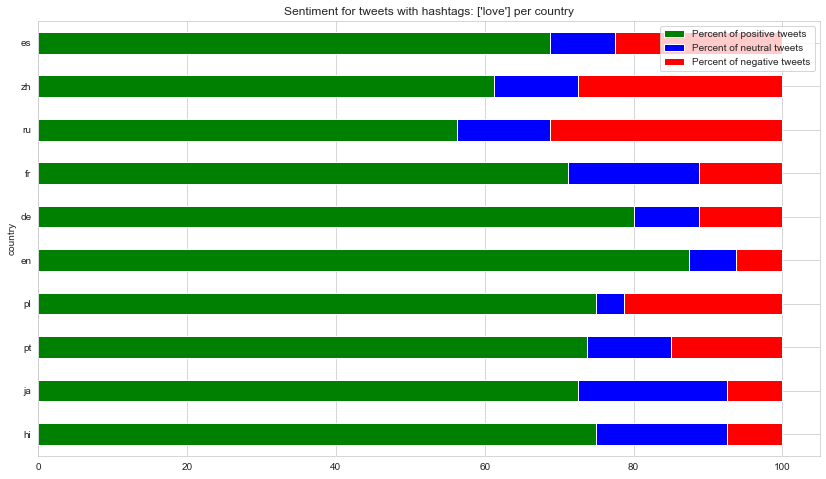

In [41]:
analyze_twitter(['hi', 'ja', 'pt', 'pl', 'en', 'de', 'fr', 'ru', 'zh', 'es'], ["love"], max_results=80)

### Possibly neutral subject

**Language: hi**<br>**Most positive tweet (0.8):**<br>@AnuragJaisingh @rainetterouge @Poornim53171329 @manas231091 @KrazyGal92 @HrithikianMadhu @hgoyal1 @iHrithik @Deshpremi_Gujju @Angelic_Duggu Nice bhai , great cooking skills, Kab khane pe aaye aap ke ghar<br>@AnuragJaisingh @rainetterouge @ Poornim53171329 @ manas231091 @ KrazyGal92 @HrithikianMadhu @ hgoyal1 @iHrithik @Deshpremi_Gujju @Angelic_Duggu Nice bhai, great cooking skills, Kab khane pe aaye aap ke ghar<br>

**Most negative tweet (-0.7):**<br>महंगी हुई रसोई: 3 महीने में 40 रुपये प्रति लीटर तक बढ़े खाद्य तेलों के दाम https://t.co/KJ412H7GAh<br>Kitchen becomes expensive: Price of edible oils increased by Rs 40 per liter in 3 months https://t.co/KJ412H7GAh<br>

**Most positive sentence (0.9):**<br>Cooking is also a therapy, science says that the hobby of cooking keeps you healthy and makes your relationships better!<br>

**Most negative sentence (-0.8):**<br>Ayodhya saints accused the agitating peasants of agitating farmers, saying - all these are only cooking their political bread ..<br>

**Language: ja**<br>**Most positive tweet (0.9):**<br>@Cooking_Noriko おはようございます😊
何気に シュールで 朝から 笑わせてもらいましたー🙋‍♀️
今日も 良い一日でஐ♡🍀~ஐ<br>@Cooking_Noriko Good morning 😊
I was surreal and made me laugh from the morning 🙋‍♀️
Today is also a good day ஐ ♡ 🍀 ~ ஐ<br>

**Most negative tweet (-0.4):**<br>何をcooking（つくろ）〜かなぁ。cookには、ごまかす、という意味がある。
もう菅はわれわれ庶民をごまかさずにちゃんとした仕事をしてほしいー！ https://t.co/l5lPpdjPVv<br>What are you cooking? Cook has the meaning of cheating.
Suga wants us to do a decent job without cheating on the common people! https://t.co/l5lPpdjPVv<br>

**Most positive sentence (0.9):**<br>@Cooking_Noriko Good morning 😊
I was surreal and made me laugh from the morning 🙋‍♀️
Today is also a good day ஐ ♡ 🍀 ~ ஐ<br>

**Most negative sentence (-0.8):**<br>I'm sorry if it has already appeared.<br>

**Language: pt**<br>**Most positive tweet (0.9):**<br>só observando o @whoisluke_ jogando cooking craze no meu celular e passando todas as fases com a maior facilidade, um gênio mesmo<br>just watching @whoisluke_ playing cooking craze on my phone and going through all the levels with the greatest ease, a genius<br>

**Most negative tweet (-0.6):**<br>eu sou muito ruim no cooking simulator<br>I'm really bad at cooking simulator<br>

**Most positive sentence (0.9):**<br>They are delicious and remind me of my childhood.<br>

**Most negative sentence (-0.9):**<br>Japanese hate you https://t.co/6agpQVHTgM<br>

**Language: pl**<br>**Most positive tweet (0.9):**<br>Jennie amazing rapping 
Jennie singing 
Jennie dancing
Jennie cute
Jennie ace
Jennie fashion
Jennie adorable 
Jennie cooking
Jennie love<br>Jennie amazing rapping
Jennie singing
Jennie dancing
Jennie cute
Jennie ace
Jennie fashion
Jennie is adorable
Jennie cooking
Jennie love<br>

**Most negative tweet (-0.8):**<br>jakie to jest smutne że mi tak mężczyzna potrafi zawrócić w głowie, im ashamed of myself but also yes i do the cooking yes i do the cleaning<br>how sad it is that such a man can turn my head, im ashamed of myself but also yes i do the cooking yes i do the cleaning<br>

**Most positive sentence (0.9):**<br>Jennie amazing rapping
Jennie singing
Jennie dancing
Jennie cute
Jennie ace
Jennie fashion
Jennie is adorable
Jennie cooking
Jennie love<br>

**Most negative sentence (-0.8):**<br>how sad it is that such a man can turn my head, im ashamed of myself but also yes i do the cooking yes i do the cleaning<br>

**Language: en**<br>**Most positive tweet (0.9):**<br>See you tomorrow! Lots of cooking temptation! Can’t wait 😝 https://t.co/pWq74qqDzP<br>See you tomorrow! Lots of cooking temptation! Can’t wait 😝 https://t.co/pWq74qqDzP<br>

**Most negative tweet (-0.9):**<br>Tired from doing nothing except going for a walk and cooking loool what the fuck<br>Tired from doing nothing except going for a walk and cooking loool what the fuck<br>

**Most positive sentence (0.9):**<br>Definitely, a thousand times yes!<br>

**Most negative sentence (-0.9):**<br>Tired from doing nothing except going for a walk and cooking loool what the fuck<br>

**Language: de**<br>**Most positive tweet (0.9):**<br>Dieser wunderbare Text von @marvin_xn spricht mir aus der Seele: https://t.co/9BZilaFjcU #kochen #essen #food #cooking #culture<br>This wonderful text by @marvin_xn speaks from my soul: https://t.co/9BZilaFjcU #kochen #essen #food #cooking #culture<br>

**Most negative tweet (-0.6):**<br>hab mir heut morgen aus frust cooking mama für die switch bestellt.<br>I ordered my frustration for cooking mom this morning for the switch.<br>

**Most positive sentence (0.9):**<br>I'm really looking forward to the Pizza Cooking Simulator later and can't wait.<br>

**Most negative sentence (-0.8):**<br>Unfortunately, the service from Vorwerk is not recommended<br>

**Language: fr**<br>**Most positive tweet (0.9):**<br>Bon Appétit! #cooking #recipeoftheday #delicious https://t.co/6yj8HEzvlD<br>Enjoy your meal! #cooking #recipeoftheday #delicious https://t.co/6yj8HEzvlD<br>

**Most negative tweet (-0.8):**<br>@let08936661 Et son copain Podesta et elle vont bientôt partager une cellule en attendant d'être éxécutés pour leurs petites soirée Spirit Cooking et torture d'enfants
https://t.co/HMVUzed1Uv<br>@ let08936661 And her boyfriend Podesta and she will soon be sharing a cell while waiting to be executed for their little Spirit Cooking and child torture parties
https://t.co/HMVUzed1Uv<br>

**Most positive sentence (0.9):**<br>Universal fit fo all Combi Ovens and ideal for a range of cooking styles.<br>

**Most negative sentence (-0.8):**<br>@ let08936661 And her boyfriend Podesta and she will soon be sharing a cell while waiting to be executed for their little Spirit Cooking and child torture parties
https://t.co/HMVUzed1Uv<br>

**Language: ru**<br>**Most positive tweet (0.8):**<br>@mr_The Очень много такого, начать стоит с Harold McGee – On Food and Cooking, а продолжить какими-нибудь классными книгами про хлеб вообще типа Tartine, Crumb и так далее<br>@mr_The There is a lot of that, it's worth starting with Harold McGee - On Food and Cooking, and continue with some cool books about bread in general, like Tartine, Crumb, and so on<br>

**Most negative tweet (-0.7):**<br>@Blues_cooking @bubnov_alexey_v Идеальное некрасиво 😁 «я помню все твои трещинки...» и вот это вот всё<br>@Blues_cooking @bubnov_alexey_v The ideal is ugly 😁 "I remember all your cracks ..." and that's it<br>

**Most positive sentence (0.9):**<br>you can add whatever you want!<br>

**Most negative sentence (-0.7):**<br>@Blues_cooking @bubnov_alexey_v The ideal is ugly 😁 "I remember all your cracks ..." and that's it<br>

**Language: zh**<br>**Most positive tweet (0.9):**<br>樂在廚中星期天
Joyful cooking Sunday https://t.co/DskiVHIP9l<br>Happy in the kitchen on Sunday
Joyful cooking Sunday https://t.co/DskiVHIP9l<br>

**Most negative tweet (-0.4):**<br>【料理猫王Cooking cat】今天搞点西北羊排，可惜本喵一口都没吃到 baked lamp chop https://t.co/Rtie49gUVM via @YouTube<br>[Cooking cat] I made some northwest lamb chop today, but it’s a pity that Ben Miao didn’t get a bite of baked lamp chop https://t.co/Rtie49gUVM via @YouTube<br>

**Most positive sentence (0.9):**<br>Eat it!<br>

**Most negative sentence (-0.8):**<br>Zhongshan wolves all give Laozi to eat shit💩Hunan Party History Hei The evil spy gang 👉 This notoriously wanted by the Central and Sichuan Public Security has been filled with a urinal for Laozi!<br>

**Language: es**<br>**Most positive tweet (0.9):**<br>Cooking su comida favorita https://t.co/lXpdFWmRW4<br>Cooking your favorite food https://t.co/lXpdFWmRW4<br>

**Most negative tweet (-0.8):**<br>@ChuletayLulada A Todos mis años jugando cooking mama les duele esto.<br>@ChuletayLulada All my years playing cooking mom this hurts.<br>

**Most positive sentence (0.9):**<br>When you like, we will see a suspense;)<br>

**Most negative sentence (-0.9):**<br>So my E6, the person who is supposed to take care of me .... who is fucking me knowing my partner, wants me to blackmail from fraternization because I have a SHARP case cooking up his ass.<br>

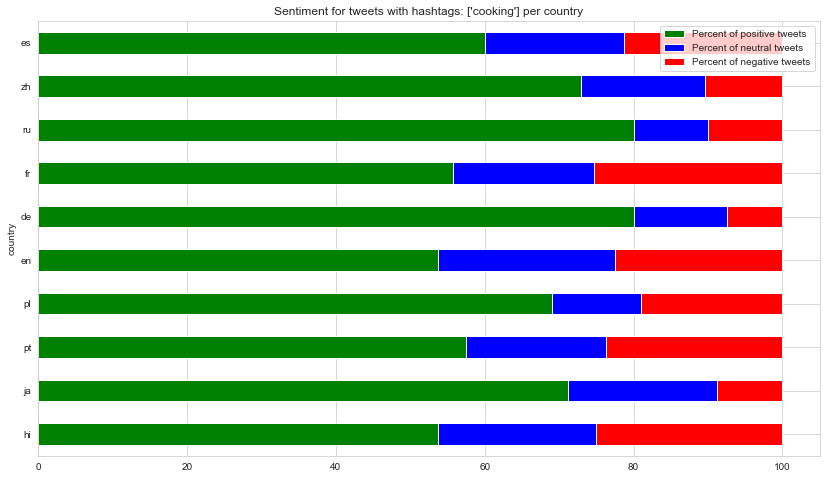

In [42]:
analyze_twitter(['hi', 'ja', 'pt', 'pl', 'en', 'de', 'fr', 'ru', 'zh', 'es'], ["cooking"], max_results=80)

### Subject possibly controversial between countries

**Language: hi**<br>**Most positive tweet (0.4):**<br>@CNNnews18 Ok. Jharkhand USA mein hain. https://t.co/SeijUOnOUa<br>@ CNNnews18 Ok. Jharkhand USA mein hain. https://t.co/SeijUOnOUa<br>

**Most negative tweet (-0.8):**<br>और ना ही कोई USA का पता लिखा गया है
अगूठा का निशान भी उनका नहीं है https://t.co/ZWviNtSk1O<br>Nor is any usa address written
His thumb impression is also not his https://t.co/ZWviNtSk1O<br>

**Most positive sentence (0.8):**<br>@ CNNnews18 Ok.<br>

**Most negative sentence (-0.8):**<br>Sa has been molested in the October 2014 anonymity
And also sold our share illegally and illegally<br>

**Language: ja**<br>**Most positive tweet (0.9):**<br>@usa_maria320 おはようございます(=^ェ^=)これから出勤っす☺️今日も１日笑顔で頑張っていきまっしょい✋😄<br>@ usa_maria320 Good morning (= ^ e ^ =) I'm going to work from now on ☺️ I'll do my best with a smile all day today ✋😄<br>

**Most negative tweet (-0.8):**<br>米下院、トランプ大統領を２度目の弾劾訴追 米下院は１３日、先週の連邦議会議事堂での暴動で「反乱の扇動」を行ったとして、トランプ大統領の弾劾訴追決議案を賛成多数で  https://t.co/NlcjflDG76<br>U.S. House of Representatives accuses President Trump of second denunciation /t.co/NlcjflDG76<br>

**Most positive sentence (0.9):**<br>@ usa_maria320 Good morning (= ^ e ^ =) I'm going to work from now on ☺️ I'll do my best with a smile all day today ✋😄<br>

**Most negative sentence (-0.8):**<br>ass fu pulling hair.<br>

**Language: pt**<br>**Most positive tweet (0.8):**<br>@NorisBotelho @pfvr_vi ia sugerir isso, dançar é um excelente exercício físico que não é nada chato. E se resolver sambar então, só vejo vantagens, deixa o corpo lindo e te dá aquele jogo de cintura que você usa pra tudo ;)<br>@NorisBotelho @pfvr_vi would suggest that, dancing is an excellent physical exercise that is not at all boring. And if you decide to samba then, I only see advantages, it makes your body beautiful and gives you that waist game you use for everything;)<br>

**Most negative tweet (-0.9):**<br>alight motion seu filho duma puta desgraçada estourada, pode me explica por que que na única vez que eu vo usa vc, vc decide ser um pau no cu e nao mostrar na mídia pra carregar pra editar a porcaria da merda do video que eu baixei??????????te odeio seu bosta<br>alight motion your son of a busted bastard, can you explain to me why the only time i use you, you decide to be a dick in the ass and not show it in the media to upload to edit the goddamn video shit i downloaded? ????????? i hate you shit<br>

**Most positive sentence (0.9):**<br>@karinafdefaesa This last video is perfect, as she uses salt and seasoning in everything from rice to salad.<br>

**Most negative sentence (-0.9):**<br>alight motion your son of a busted bastard, can you explain to me why the only time i use you, you decide to be a dick in the ass and not show it in the media to upload to edit the goddamn video shit i downloaded? ?????????<br>

**Language: pl**<br>**Most positive tweet (0.9):**<br>@lutieneth1 Żydzi z USA, Izraela i Ukraińcy lubią to ;)<br>@ lutieneth1 Jews from the USA, Israel and Ukrainians like it;)<br>

**Most negative tweet (-0.8):**<br>@Tysol @cezarykrysztopa Demokraci to teraz jak komuniści i faszyści "kto nie jest z nami, jest przeciwko nam" 🙄 Dobrze widac, że te Komunistyczne Władze w USA obawiają się, że Trump za cztery lata wystartuje ponownie i po prostu wygra w cuglach...<br>@Tysol @cezarykrysztopa Demokraci are now like communists and fascists "who is not with us is against us" 🙄 You can see that these US Communist authorities are afraid that Trump will start again in four years and will simply win the reins .. .<br>

**Most positive sentence (0.9):**<br>@ lutieneth1 Jews from the USA, Israel and Ukrainians like it;)<br>

**Most negative sentence (-0.9):**<br>Stop raving man, I have already proved to you that you have no idea what freedom of speech is in the USA and in the world and you are still trying to disturb something?<br>

**Language: en**<br>**Most positive tweet (0.6):**<br>@KevanKenney @MTV REQUEST @dimash_official @MTV #FridayLivestream 

because he is just a good man, not only the best Singer on the world ❤️
@FansDimash #dears @Dimash_DKIFC @dimash_usa https://t.co/xv14opiUg3<br>@KevanKenney @MTV REQUEST @dimash_official @MTV #FridayLivestream 

because he is just a good man, not only the best Singer on the world ❤️
@FansDimash #dears @Dimash_DKIFC @dimash_usa https://t.co/xv14opiUg3<br>

**Most negative tweet (-0.8):**<br>You’re all disgraceful.  @DonaldJTrumpJr @EricTrump @IvankaTrump Donald is a clear and present danger to the USA.  Sadly, Donald Trump impeached for a second time! Sad stain on the history of our country.  Your kids will be reading about this... sad for them.<br>You’re all disgraceful.  @DonaldJTrumpJr @EricTrump @IvankaTrump Donald is a clear and present danger to the USA.  Sadly, Donald Trump impeached for a second time! Sad stain on the history of our country.  Your kids will be reading about this... sad for them.<br>

**Most positive sentence (0.9):**<br>because he is just a good man, not only the best Singer on the world ❤️
@FansDimash #dears @Dimash_DKIFC @dimash_usa https://t.co/xv14opiUg3<br>

**Most negative sentence (-0.9):**<br>You’re all disgraceful.<br>

**Language: de**<br>**Most positive tweet (0.9):**<br>Größter Starstruckmoment meines Lebens Petar Radenković getroffen und eben gelesen er hatte Bruder der in 60er Jahren Sänger in USA war mit Namen Milan the leather boy wie geil kann es sein<br>Biggest Starstruck moment of my life met Petar Radenković and just read he had brother who was a singer in the USA in the 60s with the name Milan the leather boy how awesome it can be<br>

**Most negative tweet (-0.7):**<br>Unsere Medien haben die USA zu Beginn der Pandemie wegen der hohen Todeszahlen scharf kritisiert. Jetzt, wo die Todeszahlen (je 100.000 Einwohner) in Deutschland höher als in den USA sind schweigen sie.<br>Our media sharply criticized the US at the beginning of the pandemic because of the high death toll. Now that the death rate (per 100,000 inhabitants) in Germany is higher than in the USA, they are silent.<br>

**Most positive sentence (0.9):**<br>Biggest Starstruck moment of my life met Petar Radenković and just read he had brother who was a singer in the USA in the 60s with the name Milan the leather boy how awesome it can be<br>

**Most negative sentence (-0.9):**<br>The hatred must extr.<br>

**Language: fr**<br>**Most positive tweet (0.9):**<br>j'aime les usa du monde moni<br>i love the usa of the world moni<br>

**Most negative tweet (-0.8):**<br>aux USA ils sont perchés d’une manière ptdddrrr ils ont balancer leur zgeg en commentaire comme si c’était normal https://t.co/Xp3k84cPnW<br>in the USA they are perched in a ptdddrrr way they swing their cock in comment as if it were normal https://t.co/Xp3k84cPnW<br>

**Most positive sentence (0.9):**<br>The episodes of #LaChute await you 👇👇👇 clear, concise and well done.<br>

**Most negative sentence (-0.8):**<br>You will hear first woman and more black as VP
And she sucks<br>

**Language: ru**<br>**Most positive tweet (0.9):**<br>Великие и могучие😂😂😂 #USA #1984IsHere https://t.co/TvrBLO9Yvf<br>Great and mighty😂😂😂 #USA # 1984IsHere https://t.co/TvrBLO9Yvf<br>

**Most negative tweet (-0.8):**<br>Неясные критерии - опасность для свободы слова. В #ЕК раскритиковали блокировку Трампа в соцсетях : https://t.co/3pSZyaFN3w #usa #Trump #twitter #Facebook #451F #сша #Маккартизм #Трамп #eu #europe #OSCE  #цензура #Orwell1984 #СвободаСлова<br>Unclear criteria are a danger to freedom of speech. # EK criticized the blocking of Trump on social networks: https://t.co/3pSZyaFN3w #usa #Trump #twitter #Facebook # 451F # USA # McCarthyism # Trump #eu #europe #OSCE # censorship # Orwell1984 #Freedom of speech<br>

**Most positive sentence (0.9):**<br>The people and the Democratic Party are one!<br>

**Most negative sentence (-0.9):**<br>@duke_helena @gofundme politicians manipulate people, come and go
Political views are changing.<br>

**Language: zh**<br>**Most positive tweet (0.9):**<br>@DongFang_USA 这逻辑真他妈的强大！<br>@DongFang_USA This logic is so fucking powerful!<br>

**Most negative tweet (-0.9):**<br>@DongFang_USA 他在胡说八道！<br>@DongFang_USA He is talking nonsense!<br>

**Most positive sentence (0.9):**<br>@senatemajldr @benshapiro China sincerely thank you for your service over the past 4 years.<br>

**Most negative sentence (-0.9):**<br>@DongFang_USA He is talking nonsense!<br>

**Language: es**<br>**Most positive tweet (0.9):**<br>@jfc2115 @garciabanchs Gran vaina como muchos pendejos como  tu q creyeron en Chávez pero resulta q es el mejor presidente q ha tenido usa ganó sobrado<br>@ jfc2115 @garciabanchs Great pod like many assholes like you who believed in Chávez but it turns out that he is the best president that the usa has had, he won more than enough<br>

**Most negative tweet (-0.8):**<br>@kosbestie @Keninis_World Que pendejo el que usa "joto, maricon o puto" como insulto, no solo demuestra que su casa no tiene puertas y techo de lámina si no que también hasta es ignorante, adefecio mal hecho<br>@kosbestie @Keninis_World What an idiot who uses "joto, fagot or puto" as an insult, not only shows that his house does not have doors and a tin roof but is also ignorant, poorly made adefection<br>

**Most positive sentence (0.9):**<br>The Democrats made that country a great PROSTITUTE🇺🇸<br>

**Most negative sentence (-0.9):**<br>@ Charlie_g42 @ Natalin441 You are a complete idiot, if they saved 100,000 million is why they did not give it to them, another idiot that uses "Had", are they not ashamed of being such idiots?<br>

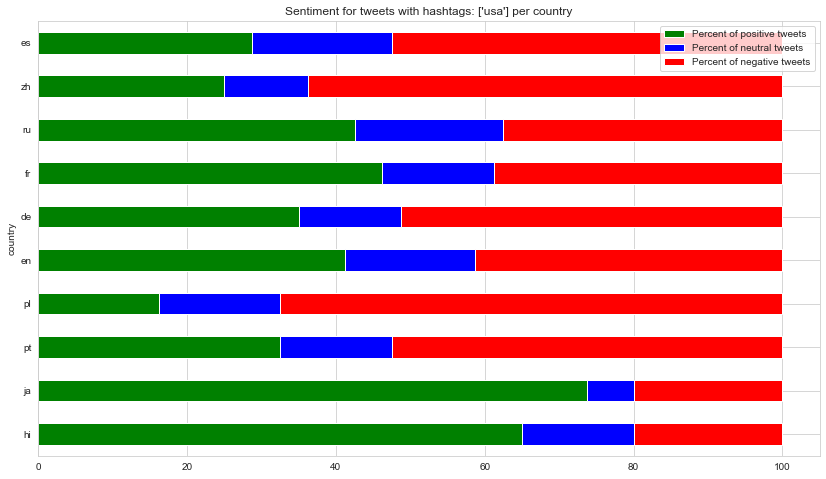

In [43]:
analyze_twitter(['hi', 'ja', 'pt', 'pl', 'en', 'de', 'fr', 'ru', 'zh', 'es'], ["usa"], max_results=80)